In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 2.63 s, sys: 3.1 s, total: 5.73 s
Wall time: 1.99 s


In [2]:
# papermill parameters
SEED_LIST = [
             0,
             #1111,
             #2222, 
             #3333, 
             #4444, 
             #5555,
             #6666,
             #7777,
             #8888,
             #9999
            ]

#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
# Parameters
SEED_LIST = [0]
TICKERS = [
    "VALE",
    "ITUB",
    "PBR-A",
    "BBD",
    "PBR",
    "AMXL.MX",
    "WALMEX.MX",
    "FEMSAUBD.MX",
    "GFNORTEO.MX",
    "WEGE3.SA",
    "BBAS3.SA",
    "BAP",
    "CEMEXCPO.MX",
    "SQM",
    "SCCO",
    "GGB",
    "CHILE.SN",
    "ENIA",
    "CIB",
    "TLEVISACPO.MX",
    "EC",
    "BRFS",
    "BSAC",
    "CCRO3.SA",
]
MARKET_NAME = "LA_40"
MODEL_BASE_NAME = "RL_CNN"
FROM = "2014-12-01"
UNTIL = "2016-01-01"
NB_EPISODES = 200
GAMMA_TRADES = [0.1, 1, 7, 8, 9, 10, 11, 12, 50, 100, 1000]
GAMMA_RISKS = [
    1,
    2,
    3,
    6,
    10,
    18,
    32,
    56,
    100,
    178,
    316,
    562,
    1000,
    5000,
    10000,
    100000,
]
GAMMA_HOLDS = [0.1, 1, 10, 100, 1000, 10000, 100000]


In [4]:
#------ small test-sweep ------#
# GAMMA_TRADES = [0.1, 1, 10, 100]
# GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
# GAMMA_HOLDS = [0.1, 1]
#------ extended-boyd-sweep ------#
# GAMMA_TRADES =  [0.1, 0.5, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 11, 12, 15, 20, 30, 45, 60, 100, 200]
# GAMMA_RISKS = [0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 2000, 5000, 10000, 20000]
#---------------------------------#

GAMMA_TRIOS = []
for tr in GAMMA_TRADES:
    for ri in GAMMA_RISKS:
        for hd in GAMMA_HOLDS:
            GAMMA_TRIOS.append((tr, ri, hd))
        
#format: (gamma_trade, gamma_risk, gamma_hold)
print('number of trios: ', len(GAMMA_TRIOS))
#GAMMA_TRIOS

number of trios:  1232


In [5]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

## create agent(s) and backtest in new backtest env

In [6]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIOS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIOS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            #print(e)

creating environment and agent...


backtesting:
	[1/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=0.1, seed=0...


	[2/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=1, seed=0...


	[3/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=10, seed=0...


	[4/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=100, seed=0...


	[5/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=1000, seed=0...


	[6/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=10000, seed=0...


	[7/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=100000, seed=0...


	[8/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=0.1, seed=0...


	[9/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=1, seed=0...


	[10/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=10, seed=0...


	[11/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=100, seed=0...


	[12/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=1000, seed=0...


	[13/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=10000, seed=0...


	[14/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=2, gamma_hold=100000, seed=0...


	[15/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=0.1, seed=0...


	[16/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=1, seed=0...


	[17/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=10, seed=0...


	[18/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=100, seed=0...


	[19/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=1000, seed=0...


	[20/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=10000, seed=0...


	[21/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=3, gamma_hold=100000, seed=0...


	[22/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=0.1, seed=0...


	[23/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=1, seed=0...


	[24/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=10, seed=0...


	[25/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=100, seed=0...


	[26/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=1000, seed=0...


	[27/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=10000, seed=0...


	[28/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=6, gamma_hold=100000, seed=0...


	[29/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=0.1, seed=0...


	[30/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=1, seed=0...


	[31/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=10, seed=0...


	[32/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=100, seed=0...


	[33/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=1000, seed=0...


	[34/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=10000, seed=0...


	[35/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=100000, seed=0...


	[36/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=0.1, seed=0...


	[37/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=1, seed=0...


	[38/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=10, seed=0...


	[39/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=100, seed=0...


	[40/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=1000, seed=0...


	[41/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=10000, seed=0...


	[42/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=100000, seed=0...


	[43/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=0.1, seed=0...


	[44/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=1, seed=0...


	[45/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=10, seed=0...


	[46/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=100, seed=0...


	[47/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=1000, seed=0...


	[48/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=10000, seed=0...


	[49/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=32, gamma_hold=100000, seed=0...


	[50/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=0.1, seed=0...


	[51/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=1, seed=0...


	[52/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=10, seed=0...


	[53/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=100, seed=0...


	[54/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=1000, seed=0...


	[55/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=10000, seed=0...


	[56/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=100000, seed=0...


	[57/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=0.1, seed=0...


	[58/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=1, seed=0...


	[59/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=10, seed=0...


	[60/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=100, seed=0...


	[61/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=1000, seed=0...


	[62/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=10000, seed=0...


	[63/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=100000, seed=0...


	[64/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=0.1, seed=0...


	[65/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=1, seed=0...


	[66/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=10, seed=0...


	[67/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=100, seed=0...


	[68/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=1000, seed=0...


	[69/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=10000, seed=0...


	[70/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=178, gamma_hold=100000, seed=0...


	[71/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=0.1, seed=0...


	[72/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=1, seed=0...


	[73/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=10, seed=0...


	[74/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=100, seed=0...


	[75/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=1000, seed=0...


	[76/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=10000, seed=0...


	[77/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=316, gamma_hold=100000, seed=0...


	[78/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=0.1, seed=0...


	[79/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=1, seed=0...


	[80/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=10, seed=0...


	[81/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=100, seed=0...


	[82/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=1000, seed=0...


	[83/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=10000, seed=0...


	[84/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=100000, seed=0...


	[85/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[86/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=1, seed=0...


	[87/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=10, seed=0...


	[88/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=100, seed=0...


	[89/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=1000, seed=0...


	[90/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=10000, seed=0...


	[91/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=100000, seed=0...


	[92/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[93/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=1, seed=0...


	[94/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=10, seed=0...


	[95/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=100, seed=0...


	[96/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=1000, seed=0...


	[97/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=10000, seed=0...


	[98/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=5000, gamma_hold=100000, seed=0...


	[99/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[100/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=1, seed=0...


	[101/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=10, seed=0...


	[102/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=100, seed=0...


	[103/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=1000, seed=0...


	[104/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=10000, seed=0...


	[105/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=10000, gamma_hold=100000, seed=0...


	[106/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[107/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=1, seed=0...


	[108/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=10, seed=0...


	[109/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=100, seed=0...


	[110/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=1000, seed=0...


	[111/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=10000, seed=0...


	[112/1232]	RL_CNN: gamma_trade=0.1, gamma_risk=100000, gamma_hold=100000, seed=0...


	[113/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=0.1, seed=0...


	[114/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=1, seed=0...


	[115/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=10, seed=0...


	[116/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=100, seed=0...


	[117/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=1000, seed=0...


	[118/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=10000, seed=0...


	[119/1232]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=100000, seed=0...


	[120/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=0.1, seed=0...


	[121/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=1, seed=0...


	[122/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=10, seed=0...
**error for model: trade_1_risk_2_hold_10
	[123/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=100, seed=0...


	[124/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=1000, seed=0...


	[125/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=10000, seed=0...


	[126/1232]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=100000, seed=0...


	[127/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=0.1, seed=0...


	[128/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=1, seed=0...


	[129/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=10, seed=0...


	[130/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=100, seed=0...


	[131/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=1000, seed=0...


	[132/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=10000, seed=0...


	[133/1232]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=100000, seed=0...


	[134/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=0.1, seed=0...


	[135/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=1, seed=0...


	[136/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=10, seed=0...


	[137/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=100, seed=0...


	[138/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=1000, seed=0...


	[139/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=10000, seed=0...


	[140/1232]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=100000, seed=0...


	[141/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=0.1, seed=0...


	[142/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=1, seed=0...


	[143/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=10, seed=0...


	[144/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=100, seed=0...


	[145/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=1000, seed=0...


	[146/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=10000, seed=0...


	[147/1232]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=100000, seed=0...


	[148/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=0.1, seed=0...


	[149/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=1, seed=0...


	[150/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=10, seed=0...


	[151/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=100, seed=0...


	[152/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=1000, seed=0...


	[153/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=10000, seed=0...


	[154/1232]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=100000, seed=0...


	[155/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=0.1, seed=0...


	[156/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=1, seed=0...


	[157/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=10, seed=0...


	[158/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=100, seed=0...


	[159/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=1000, seed=0...


	[160/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=10000, seed=0...


	[161/1232]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=100000, seed=0...


	[162/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=0.1, seed=0...


	[163/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=1, seed=0...


	[164/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=10, seed=0...


	[165/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=100, seed=0...


	[166/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=1000, seed=0...


	[167/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=10000, seed=0...


	[168/1232]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=100000, seed=0...


	[169/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=0.1, seed=0...


	[170/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=1, seed=0...


	[171/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=10, seed=0...


	[172/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=100, seed=0...


	[173/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=1000, seed=0...


	[174/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=10000, seed=0...


	[175/1232]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=100000, seed=0...


	[176/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=0.1, seed=0...


	[177/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=1, seed=0...


	[178/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=10, seed=0...


	[179/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=100, seed=0...


	[180/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=1000, seed=0...


	[181/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=10000, seed=0...


	[182/1232]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=100000, seed=0...


	[183/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=0.1, seed=0...


	[184/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=1, seed=0...


	[185/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=10, seed=0...


	[186/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=100, seed=0...


	[187/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=1000, seed=0...


	[188/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=10000, seed=0...


	[189/1232]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=100000, seed=0...


	[190/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=0.1, seed=0...


	[191/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=1, seed=0...


	[192/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=10, seed=0...


	[193/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=100, seed=0...


	[194/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=1000, seed=0...


	[195/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=10000, seed=0...


	[196/1232]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=100000, seed=0...


	[197/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[198/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=1, seed=0...


	[199/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=10, seed=0...


	[200/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=100, seed=0...


	[201/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=1000, seed=0...


	[202/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=10000, seed=0...


	[203/1232]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=100000, seed=0...


	[204/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[205/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=1, seed=0...


	[206/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=10, seed=0...


	[207/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=100, seed=0...


	[208/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=1000, seed=0...


	[209/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=10000, seed=0...


	[210/1232]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=100000, seed=0...


	[211/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[212/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=1, seed=0...


	[213/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=10, seed=0...


	[214/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=100, seed=0...


	[215/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=1000, seed=0...


	[216/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=10000, seed=0...


	[217/1232]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=100000, seed=0...


	[218/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[219/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=1, seed=0...


	[220/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=10, seed=0...


	[221/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=100, seed=0...


	[222/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=1000, seed=0...


	[223/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=10000, seed=0...


	[224/1232]	RL_CNN: gamma_trade=1, gamma_risk=100000, gamma_hold=100000, seed=0...


	[225/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=0.1, seed=0...


	[226/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1, seed=0...


	[227/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10, seed=0...


	[228/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=100, seed=0...


	[229/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1000, seed=0...


	[230/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10000, seed=0...


	[231/1232]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=100000, seed=0...


	[232/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=0.1, seed=0...


	[233/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1, seed=0...


	[234/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10, seed=0...


	[235/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=100, seed=0...


	[236/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1000, seed=0...


	[237/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10000, seed=0...


	[238/1232]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=100000, seed=0...


	[239/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=0.1, seed=0...


	[240/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1, seed=0...


	[241/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10, seed=0...


	[242/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=100, seed=0...


	[243/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1000, seed=0...


	[244/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10000, seed=0...


	[245/1232]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=100000, seed=0...


	[246/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=0.1, seed=0...


	[247/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1, seed=0...


	[248/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10, seed=0...


	[249/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=100, seed=0...


	[250/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1000, seed=0...


	[251/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10000, seed=0...


	[252/1232]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=100000, seed=0...


	[253/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=0.1, seed=0...


	[254/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1, seed=0...


	[255/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10, seed=0...


	[256/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=100, seed=0...


	[257/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1000, seed=0...


	[258/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10000, seed=0...


	[259/1232]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=100000, seed=0...


	[260/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=0.1, seed=0...


	[261/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1, seed=0...


	[262/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10, seed=0...


	[263/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=100, seed=0...


	[264/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1000, seed=0...


	[265/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10000, seed=0...


	[266/1232]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=100000, seed=0...


	[267/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=0.1, seed=0...


	[268/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1, seed=0...


	[269/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10, seed=0...


	[270/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=100, seed=0...


	[271/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1000, seed=0...


	[272/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10000, seed=0...


	[273/1232]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=100000, seed=0...


	[274/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=0.1, seed=0...


	[275/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1, seed=0...


	[276/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10, seed=0...


	[277/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=100, seed=0...


	[278/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1000, seed=0...


	[279/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10000, seed=0...


	[280/1232]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=100000, seed=0...


	[281/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=0.1, seed=0...


	[282/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1, seed=0...


	[283/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10, seed=0...


	[284/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=100, seed=0...


	[285/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1000, seed=0...


	[286/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10000, seed=0...


	[287/1232]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=100000, seed=0...


	[288/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=0.1, seed=0...


	[289/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1, seed=0...


	[290/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10, seed=0...


	[291/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=100, seed=0...


	[292/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1000, seed=0...


	[293/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10000, seed=0...


	[294/1232]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=100000, seed=0...


	[295/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=0.1, seed=0...


	[296/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1, seed=0...


	[297/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10, seed=0...


	[298/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=100, seed=0...


	[299/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1000, seed=0...


	[300/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10000, seed=0...


	[301/1232]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=100000, seed=0...


	[302/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=0.1, seed=0...


	[303/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1, seed=0...


	[304/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10, seed=0...


	[305/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=100, seed=0...


	[306/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1000, seed=0...


	[307/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10000, seed=0...


	[308/1232]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=100000, seed=0...


	[309/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[310/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1, seed=0...


	[311/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10, seed=0...


	[312/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=100, seed=0...


	[313/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1000, seed=0...


	[314/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10000, seed=0...


	[315/1232]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=100000, seed=0...


	[316/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[317/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1, seed=0...


	[318/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=10, seed=0...


	[319/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=100, seed=0...


	[320/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1000, seed=0...


	[321/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=10000, seed=0...


	[322/1232]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=100000, seed=0...


	[323/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[324/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1, seed=0...


	[325/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=10, seed=0...


	[326/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=100, seed=0...


	[327/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1000, seed=0...


	[328/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=10000, seed=0...


	[329/1232]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=100000, seed=0...


	[330/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[331/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=1, seed=0...


	[332/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=10, seed=0...


	[333/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=100, seed=0...


	[334/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=1000, seed=0...


	[335/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=10000, seed=0...


	[336/1232]	RL_CNN: gamma_trade=7, gamma_risk=100000, gamma_hold=100000, seed=0...


	[337/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=0.1, seed=0...


	[338/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1, seed=0...


	[339/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10, seed=0...


	[340/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=100, seed=0...


	[341/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1000, seed=0...


	[342/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10000, seed=0...


	[343/1232]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=100000, seed=0...


	[344/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=0.1, seed=0...


	[345/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1, seed=0...


	[346/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10, seed=0...


	[347/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=100, seed=0...


	[348/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1000, seed=0...


	[349/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10000, seed=0...


	[350/1232]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=100000, seed=0...


	[351/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=0.1, seed=0...


	[352/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1, seed=0...


	[353/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10, seed=0...


	[354/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=100, seed=0...


	[355/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1000, seed=0...


	[356/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10000, seed=0...


	[357/1232]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=100000, seed=0...


	[358/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=0.1, seed=0...


	[359/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1, seed=0...


	[360/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10, seed=0...


	[361/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=100, seed=0...


	[362/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1000, seed=0...


	[363/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10000, seed=0...


	[364/1232]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=100000, seed=0...


	[365/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=0.1, seed=0...


	[366/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1, seed=0...


	[367/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10, seed=0...


	[368/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=100, seed=0...


	[369/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1000, seed=0...


	[370/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10000, seed=0...


	[371/1232]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=100000, seed=0...


	[372/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=0.1, seed=0...


	[373/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1, seed=0...


	[374/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10, seed=0...


	[375/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=100, seed=0...


	[376/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1000, seed=0...


	[377/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10000, seed=0...


	[378/1232]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=100000, seed=0...


	[379/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=0.1, seed=0...


	[380/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1, seed=0...


	[381/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10, seed=0...


	[382/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=100, seed=0...


	[383/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1000, seed=0...


	[384/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10000, seed=0...


	[385/1232]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=100000, seed=0...


	[386/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=0.1, seed=0...


	[387/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1, seed=0...


	[388/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10, seed=0...


	[389/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=100, seed=0...


	[390/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1000, seed=0...


	[391/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10000, seed=0...


	[392/1232]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=100000, seed=0...


	[393/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=0.1, seed=0...


	[394/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1, seed=0...


	[395/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10, seed=0...


	[396/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=100, seed=0...


	[397/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1000, seed=0...


	[398/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10000, seed=0...


	[399/1232]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=100000, seed=0...


	[400/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=0.1, seed=0...


	[401/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1, seed=0...


	[402/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10, seed=0...


	[403/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=100, seed=0...


	[404/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1000, seed=0...


	[405/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10000, seed=0...


	[406/1232]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=100000, seed=0...


	[407/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=0.1, seed=0...


	[408/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1, seed=0...


	[409/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10, seed=0...


	[410/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=100, seed=0...


	[411/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1000, seed=0...


	[412/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10000, seed=0...


	[413/1232]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=100000, seed=0...


	[414/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=0.1, seed=0...


	[415/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1, seed=0...


	[416/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10, seed=0...


	[417/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=100, seed=0...


	[418/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1000, seed=0...


	[419/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10000, seed=0...


	[420/1232]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=100000, seed=0...


	[421/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[422/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1, seed=0...


	[423/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10, seed=0...


	[424/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=100, seed=0...


	[425/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1000, seed=0...


	[426/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10000, seed=0...


	[427/1232]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=100000, seed=0...


	[428/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[429/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1, seed=0...


	[430/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=10, seed=0...


	[431/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=100, seed=0...


	[432/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1000, seed=0...


	[433/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=10000, seed=0...


	[434/1232]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=100000, seed=0...


	[435/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[436/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1, seed=0...


	[437/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=10, seed=0...


	[438/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=100, seed=0...


	[439/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1000, seed=0...


	[440/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=10000, seed=0...


	[441/1232]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=100000, seed=0...


	[442/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[443/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=1, seed=0...


	[444/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=10, seed=0...


	[445/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=100, seed=0...


	[446/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=1000, seed=0...


	[447/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=10000, seed=0...


	[448/1232]	RL_CNN: gamma_trade=8, gamma_risk=100000, gamma_hold=100000, seed=0...


	[449/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=0.1, seed=0...


	[450/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1, seed=0...


	[451/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10, seed=0...


	[452/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=100, seed=0...


	[453/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1000, seed=0...


	[454/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10000, seed=0...


	[455/1232]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=100000, seed=0...


	[456/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=0.1, seed=0...


	[457/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1, seed=0...


	[458/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10, seed=0...


	[459/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=100, seed=0...


	[460/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1000, seed=0...


	[461/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10000, seed=0...


	[462/1232]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=100000, seed=0...


	[463/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=0.1, seed=0...


	[464/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1, seed=0...


	[465/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10, seed=0...


	[466/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=100, seed=0...


	[467/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1000, seed=0...


	[468/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10000, seed=0...


	[469/1232]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=100000, seed=0...


	[470/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=0.1, seed=0...


	[471/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1, seed=0...


	[472/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10, seed=0...


	[473/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=100, seed=0...


	[474/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1000, seed=0...


	[475/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10000, seed=0...


	[476/1232]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=100000, seed=0...


	[477/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=0.1, seed=0...


	[478/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1, seed=0...


	[479/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10, seed=0...


	[480/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=100, seed=0...


	[481/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1000, seed=0...


	[482/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10000, seed=0...


	[483/1232]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=100000, seed=0...


	[484/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=0.1, seed=0...


	[485/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1, seed=0...


	[486/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10, seed=0...


	[487/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=100, seed=0...


	[488/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1000, seed=0...


	[489/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10000, seed=0...


	[490/1232]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=100000, seed=0...


	[491/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=0.1, seed=0...


	[492/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1, seed=0...


	[493/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10, seed=0...


	[494/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=100, seed=0...


	[495/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1000, seed=0...


	[496/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10000, seed=0...


	[497/1232]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=100000, seed=0...


	[498/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=0.1, seed=0...


	[499/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1, seed=0...


	[500/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10, seed=0...


	[501/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=100, seed=0...


	[502/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1000, seed=0...


	[503/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10000, seed=0...


	[504/1232]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=100000, seed=0...


	[505/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=0.1, seed=0...


	[506/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1, seed=0...


	[507/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10, seed=0...


	[508/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=100, seed=0...


	[509/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1000, seed=0...


	[510/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10000, seed=0...


	[511/1232]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=100000, seed=0...


	[512/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=0.1, seed=0...


	[513/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1, seed=0...


	[514/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10, seed=0...


	[515/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=100, seed=0...


	[516/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1000, seed=0...


	[517/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10000, seed=0...


	[518/1232]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=100000, seed=0...


	[519/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=0.1, seed=0...


	[520/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1, seed=0...


	[521/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10, seed=0...


	[522/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=100, seed=0...


	[523/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1000, seed=0...


	[524/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10000, seed=0...


	[525/1232]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=100000, seed=0...


	[526/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=0.1, seed=0...


	[527/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1, seed=0...


	[528/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10, seed=0...


	[529/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=100, seed=0...


	[530/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1000, seed=0...


	[531/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10000, seed=0...


	[532/1232]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=100000, seed=0...


	[533/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[534/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1, seed=0...


	[535/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10, seed=0...


	[536/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=100, seed=0...


	[537/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1000, seed=0...


	[538/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10000, seed=0...


	[539/1232]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=100000, seed=0...


	[540/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[541/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1, seed=0...


	[542/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=10, seed=0...


	[543/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=100, seed=0...


	[544/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1000, seed=0...


	[545/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=10000, seed=0...


	[546/1232]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=100000, seed=0...


	[547/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[548/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1, seed=0...


	[549/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=10, seed=0...


	[550/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=100, seed=0...


	[551/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1000, seed=0...


	[552/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=10000, seed=0...


	[553/1232]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=100000, seed=0...


	[554/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[555/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=1, seed=0...


	[556/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=10, seed=0...


	[557/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=100, seed=0...


	[558/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=1000, seed=0...


	[559/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=10000, seed=0...


	[560/1232]	RL_CNN: gamma_trade=9, gamma_risk=100000, gamma_hold=100000, seed=0...


	[561/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=0.1, seed=0...


	[562/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1, seed=0...


	[563/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10, seed=0...


	[564/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=100, seed=0...


	[565/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1000, seed=0...


	[566/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10000, seed=0...


	[567/1232]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=100000, seed=0...


	[568/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=0.1, seed=0...


	[569/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1, seed=0...


	[570/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10, seed=0...


	[571/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=100, seed=0...


	[572/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1000, seed=0...


	[573/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10000, seed=0...


	[574/1232]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=100000, seed=0...


	[575/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=0.1, seed=0...


	[576/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1, seed=0...


	[577/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10, seed=0...


	[578/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=100, seed=0...


	[579/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1000, seed=0...


	[580/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10000, seed=0...


	[581/1232]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=100000, seed=0...


	[582/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=0.1, seed=0...


	[583/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1, seed=0...


	[584/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10, seed=0...


	[585/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=100, seed=0...


	[586/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1000, seed=0...


	[587/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10000, seed=0...


	[588/1232]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=100000, seed=0...


	[589/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=0.1, seed=0...


	[590/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1, seed=0...


	[591/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10, seed=0...


	[592/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=100, seed=0...


	[593/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1000, seed=0...


	[594/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10000, seed=0...


	[595/1232]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=100000, seed=0...


	[596/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=0.1, seed=0...


	[597/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1, seed=0...


	[598/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10, seed=0...


	[599/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=100, seed=0...


	[600/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1000, seed=0...


	[601/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10000, seed=0...


	[602/1232]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=100000, seed=0...


	[603/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=0.1, seed=0...


	[604/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1, seed=0...


	[605/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10, seed=0...


	[606/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=100, seed=0...


	[607/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1000, seed=0...


	[608/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10000, seed=0...


	[609/1232]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=100000, seed=0...


	[610/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=0.1, seed=0...


	[611/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1, seed=0...


	[612/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10, seed=0...


	[613/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=100, seed=0...


	[614/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1000, seed=0...


	[615/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10000, seed=0...


	[616/1232]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=100000, seed=0...


	[617/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=0.1, seed=0...


	[618/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1, seed=0...


	[619/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10, seed=0...


	[620/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=100, seed=0...


	[621/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1000, seed=0...


	[622/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10000, seed=0...


	[623/1232]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=100000, seed=0...


	[624/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=0.1, seed=0...


	[625/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1, seed=0...


	[626/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10, seed=0...


	[627/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=100, seed=0...


	[628/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1000, seed=0...


	[629/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10000, seed=0...


	[630/1232]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=100000, seed=0...


	[631/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=0.1, seed=0...


	[632/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1, seed=0...


	[633/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10, seed=0...


	[634/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=100, seed=0...


	[635/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1000, seed=0...


	[636/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10000, seed=0...


	[637/1232]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=100000, seed=0...


	[638/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=0.1, seed=0...


	[639/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1, seed=0...


	[640/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10, seed=0...


	[641/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=100, seed=0...


	[642/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1000, seed=0...


	[643/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10000, seed=0...


	[644/1232]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=100000, seed=0...


	[645/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[646/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1, seed=0...


	[647/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10, seed=0...


	[648/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=100, seed=0...


	[649/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1000, seed=0...


	[650/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10000, seed=0...


	[651/1232]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=100000, seed=0...


	[652/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[653/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1, seed=0...


	[654/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=10, seed=0...


	[655/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=100, seed=0...


	[656/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1000, seed=0...


	[657/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=10000, seed=0...


	[658/1232]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=100000, seed=0...


	[659/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[660/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1, seed=0...


	[661/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=10, seed=0...


	[662/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=100, seed=0...


	[663/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1000, seed=0...


	[664/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=10000, seed=0...


	[665/1232]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=100000, seed=0...


	[666/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[667/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=1, seed=0...


	[668/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=10, seed=0...


	[669/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=100, seed=0...


	[670/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=1000, seed=0...


	[671/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=10000, seed=0...


	[672/1232]	RL_CNN: gamma_trade=10, gamma_risk=100000, gamma_hold=100000, seed=0...


	[673/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=0.1, seed=0...


	[674/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1, seed=0...


	[675/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10, seed=0...


	[676/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=100, seed=0...


	[677/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1000, seed=0...


	[678/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10000, seed=0...


	[679/1232]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=100000, seed=0...


	[680/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=0.1, seed=0...


	[681/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1, seed=0...


	[682/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10, seed=0...


	[683/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=100, seed=0...


	[684/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1000, seed=0...


	[685/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10000, seed=0...


	[686/1232]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=100000, seed=0...


	[687/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=0.1, seed=0...


	[688/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1, seed=0...


	[689/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10, seed=0...


	[690/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=100, seed=0...


	[691/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1000, seed=0...


	[692/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10000, seed=0...


	[693/1232]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=100000, seed=0...


	[694/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=0.1, seed=0...


	[695/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1, seed=0...


	[696/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10, seed=0...


	[697/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=100, seed=0...


	[698/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1000, seed=0...


	[699/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10000, seed=0...


	[700/1232]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=100000, seed=0...


	[701/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=0.1, seed=0...


	[702/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1, seed=0...


	[703/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10, seed=0...


	[704/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=100, seed=0...


	[705/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1000, seed=0...


	[706/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10000, seed=0...


	[707/1232]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=100000, seed=0...


	[708/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=0.1, seed=0...


	[709/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1, seed=0...


	[710/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10, seed=0...


	[711/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=100, seed=0...


	[712/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1000, seed=0...


	[713/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10000, seed=0...


	[714/1232]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=100000, seed=0...


	[715/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=0.1, seed=0...


	[716/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1, seed=0...


	[717/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10, seed=0...


	[718/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=100, seed=0...


	[719/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1000, seed=0...


	[720/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10000, seed=0...


	[721/1232]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=100000, seed=0...


	[722/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=0.1, seed=0...


	[723/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1, seed=0...


	[724/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10, seed=0...


	[725/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=100, seed=0...


	[726/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1000, seed=0...


	[727/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10000, seed=0...


	[728/1232]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=100000, seed=0...


	[729/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=0.1, seed=0...


	[730/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1, seed=0...


	[731/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10, seed=0...


	[732/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=100, seed=0...


	[733/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1000, seed=0...


	[734/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10000, seed=0...


	[735/1232]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=100000, seed=0...


	[736/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=0.1, seed=0...


	[737/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1, seed=0...


	[738/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10, seed=0...


	[739/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=100, seed=0...


	[740/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1000, seed=0...


	[741/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10000, seed=0...


	[742/1232]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=100000, seed=0...


	[743/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=0.1, seed=0...


	[744/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1, seed=0...


	[745/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10, seed=0...


	[746/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=100, seed=0...


	[747/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1000, seed=0...


	[748/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10000, seed=0...


	[749/1232]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=100000, seed=0...


	[750/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=0.1, seed=0...


	[751/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1, seed=0...


	[752/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10, seed=0...


	[753/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=100, seed=0...


	[754/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1000, seed=0...


	[755/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10000, seed=0...


	[756/1232]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=100000, seed=0...


	[757/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[758/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1, seed=0...


	[759/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10, seed=0...


	[760/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=100, seed=0...


	[761/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1000, seed=0...


	[762/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10000, seed=0...


	[763/1232]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=100000, seed=0...


	[764/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[765/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1, seed=0...


	[766/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=10, seed=0...


	[767/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=100, seed=0...


	[768/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1000, seed=0...


	[769/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=10000, seed=0...


	[770/1232]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=100000, seed=0...


	[771/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[772/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1, seed=0...


	[773/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=10, seed=0...


	[774/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=100, seed=0...


	[775/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1000, seed=0...


	[776/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=10000, seed=0...


	[777/1232]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=100000, seed=0...


	[778/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[779/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=1, seed=0...


	[780/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=10, seed=0...


	[781/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=100, seed=0...


	[782/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=1000, seed=0...


	[783/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=10000, seed=0...


	[784/1232]	RL_CNN: gamma_trade=11, gamma_risk=100000, gamma_hold=100000, seed=0...


	[785/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=0.1, seed=0...


	[786/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1, seed=0...


	[787/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10, seed=0...


	[788/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=100, seed=0...


	[789/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1000, seed=0...


	[790/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10000, seed=0...


	[791/1232]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=100000, seed=0...


	[792/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=0.1, seed=0...


	[793/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1, seed=0...


	[794/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10, seed=0...


	[795/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=100, seed=0...


	[796/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1000, seed=0...


	[797/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10000, seed=0...


	[798/1232]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=100000, seed=0...


	[799/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=0.1, seed=0...


	[800/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1, seed=0...


	[801/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10, seed=0...


	[802/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=100, seed=0...


	[803/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1000, seed=0...


	[804/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10000, seed=0...


	[805/1232]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=100000, seed=0...


	[806/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=0.1, seed=0...


	[807/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1, seed=0...


	[808/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10, seed=0...


	[809/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=100, seed=0...


	[810/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1000, seed=0...


	[811/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10000, seed=0...


	[812/1232]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=100000, seed=0...


	[813/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=0.1, seed=0...


	[814/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1, seed=0...


	[815/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10, seed=0...


	[816/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=100, seed=0...


	[817/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1000, seed=0...


	[818/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10000, seed=0...


	[819/1232]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=100000, seed=0...


	[820/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=0.1, seed=0...


	[821/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1, seed=0...


	[822/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10, seed=0...


	[823/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=100, seed=0...


	[824/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1000, seed=0...


	[825/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10000, seed=0...


	[826/1232]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=100000, seed=0...


	[827/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=0.1, seed=0...


	[828/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1, seed=0...


	[829/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10, seed=0...


	[830/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=100, seed=0...


	[831/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1000, seed=0...


	[832/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10000, seed=0...


	[833/1232]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=100000, seed=0...


	[834/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=0.1, seed=0...


	[835/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1, seed=0...


	[836/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10, seed=0...


	[837/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=100, seed=0...


	[838/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1000, seed=0...


	[839/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10000, seed=0...


	[840/1232]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=100000, seed=0...


	[841/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=0.1, seed=0...


	[842/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1, seed=0...


	[843/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10, seed=0...


	[844/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=100, seed=0...


	[845/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1000, seed=0...


	[846/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10000, seed=0...


	[847/1232]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=100000, seed=0...


	[848/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=0.1, seed=0...


	[849/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1, seed=0...


	[850/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10, seed=0...


	[851/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=100, seed=0...


	[852/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1000, seed=0...


	[853/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10000, seed=0...


	[854/1232]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=100000, seed=0...


	[855/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=0.1, seed=0...


	[856/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1, seed=0...


	[857/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10, seed=0...


	[858/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=100, seed=0...


	[859/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1000, seed=0...


	[860/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10000, seed=0...


	[861/1232]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=100000, seed=0...


	[862/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=0.1, seed=0...


	[863/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1, seed=0...


	[864/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10, seed=0...


	[865/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=100, seed=0...


	[866/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1000, seed=0...


	[867/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10000, seed=0...


	[868/1232]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=100000, seed=0...


	[869/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[870/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1, seed=0...


	[871/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10, seed=0...


	[872/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=100, seed=0...


	[873/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1000, seed=0...


	[874/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10000, seed=0...


	[875/1232]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=100000, seed=0...


	[876/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[877/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1, seed=0...


	[878/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=10, seed=0...


	[879/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=100, seed=0...


	[880/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1000, seed=0...


	[881/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=10000, seed=0...


	[882/1232]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=100000, seed=0...


	[883/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[884/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1, seed=0...


	[885/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=10, seed=0...


	[886/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=100, seed=0...


	[887/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1000, seed=0...


	[888/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=10000, seed=0...


	[889/1232]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=100000, seed=0...


	[890/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[891/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=1, seed=0...


	[892/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=10, seed=0...
**error for model: trade_12_risk_100000_hold_10
	[893/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=100, seed=0...


	[894/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=1000, seed=0...


	[895/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=10000, seed=0...


	[896/1232]	RL_CNN: gamma_trade=12, gamma_risk=100000, gamma_hold=100000, seed=0...


	[897/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=0.1, seed=0...


	[898/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=1, seed=0...


	[899/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=10, seed=0...


	[900/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=100, seed=0...


	[901/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=1000, seed=0...


	[902/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=10000, seed=0...


	[903/1232]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=100000, seed=0...


	[904/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=0.1, seed=0...


	[905/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=1, seed=0...


	[906/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=10, seed=0...


	[907/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=100, seed=0...


	[908/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=1000, seed=0...


	[909/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=10000, seed=0...


	[910/1232]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=100000, seed=0...


	[911/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=0.1, seed=0...


	[912/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=1, seed=0...


	[913/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=10, seed=0...


	[914/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=100, seed=0...


	[915/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=1000, seed=0...


	[916/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=10000, seed=0...


	[917/1232]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=100000, seed=0...


	[918/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=0.1, seed=0...


	[919/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=1, seed=0...


	[920/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=10, seed=0...


	[921/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=100, seed=0...


	[922/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=1000, seed=0...


	[923/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=10000, seed=0...


	[924/1232]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=100000, seed=0...


	[925/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=0.1, seed=0...


	[926/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=1, seed=0...


	[927/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=10, seed=0...


	[928/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=100, seed=0...


	[929/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=1000, seed=0...


	[930/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=10000, seed=0...


	[931/1232]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=100000, seed=0...


	[932/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=0.1, seed=0...


	[933/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=1, seed=0...


	[934/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=10, seed=0...


	[935/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=100, seed=0...


	[936/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=1000, seed=0...


	[937/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=10000, seed=0...


	[938/1232]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=100000, seed=0...


	[939/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=0.1, seed=0...


	[940/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=1, seed=0...


	[941/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=10, seed=0...


	[942/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=100, seed=0...


	[943/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=1000, seed=0...


	[944/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=10000, seed=0...


	[945/1232]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=100000, seed=0...


	[946/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=0.1, seed=0...


	[947/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=1, seed=0...


	[948/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=10, seed=0...


	[949/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=100, seed=0...


	[950/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=1000, seed=0...


	[951/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=10000, seed=0...


	[952/1232]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=100000, seed=0...


	[953/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=0.1, seed=0...


	[954/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=1, seed=0...


	[955/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=10, seed=0...


	[956/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=100, seed=0...


	[957/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=1000, seed=0...


	[958/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=10000, seed=0...


	[959/1232]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=100000, seed=0...


	[960/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=0.1, seed=0...


	[961/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=1, seed=0...


	[962/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=10, seed=0...


	[963/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=100, seed=0...


	[964/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=1000, seed=0...


	[965/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=10000, seed=0...


	[966/1232]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=100000, seed=0...


	[967/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=0.1, seed=0...


	[968/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=1, seed=0...


	[969/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=10, seed=0...


	[970/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=100, seed=0...


	[971/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=1000, seed=0...


	[972/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=10000, seed=0...


	[973/1232]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=100000, seed=0...


	[974/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=0.1, seed=0...


	[975/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=1, seed=0...


	[976/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=10, seed=0...


	[977/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=100, seed=0...


	[978/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=1000, seed=0...


	[979/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=10000, seed=0...


	[980/1232]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=100000, seed=0...


	[981/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[982/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=1, seed=0...


	[983/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=10, seed=0...


	[984/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=100, seed=0...


	[985/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=1000, seed=0...


	[986/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=10000, seed=0...


	[987/1232]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=100000, seed=0...


	[988/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[989/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=1, seed=0...


	[990/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=10, seed=0...


	[991/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=100, seed=0...


	[992/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=1000, seed=0...


	[993/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=10000, seed=0...


	[994/1232]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=100000, seed=0...


	[995/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[996/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=1, seed=0...


	[997/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=10, seed=0...


	[998/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=100, seed=0...


	[999/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=1000, seed=0...


	[1000/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=10000, seed=0...


	[1001/1232]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=100000, seed=0...


	[1002/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[1003/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=1, seed=0...


	[1004/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=10, seed=0...


	[1005/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=100, seed=0...


	[1006/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=1000, seed=0...


	[1007/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=10000, seed=0...


	[1008/1232]	RL_CNN: gamma_trade=50, gamma_risk=100000, gamma_hold=100000, seed=0...


	[1009/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=0.1, seed=0...


	[1010/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=1, seed=0...


	[1011/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=10, seed=0...


	[1012/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=100, seed=0...


	[1013/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=1000, seed=0...


	[1014/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=10000, seed=0...


	[1015/1232]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=100000, seed=0...


	[1016/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=0.1, seed=0...


	[1017/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=1, seed=0...


	[1018/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=10, seed=0...


	[1019/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=100, seed=0...


	[1020/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=1000, seed=0...


	[1021/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=10000, seed=0...


	[1022/1232]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=100000, seed=0...


	[1023/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=0.1, seed=0...


	[1024/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=1, seed=0...


	[1025/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=10, seed=0...


	[1026/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=100, seed=0...


	[1027/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=1000, seed=0...


	[1028/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=10000, seed=0...


	[1029/1232]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=100000, seed=0...


	[1030/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=0.1, seed=0...


	[1031/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=1, seed=0...


	[1032/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=10, seed=0...


	[1033/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=100, seed=0...


	[1034/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=1000, seed=0...


	[1035/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=10000, seed=0...


	[1036/1232]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=100000, seed=0...


	[1037/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=0.1, seed=0...


	[1038/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=1, seed=0...


	[1039/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=10, seed=0...


	[1040/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=100, seed=0...


	[1041/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=1000, seed=0...


	[1042/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=10000, seed=0...


	[1043/1232]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=100000, seed=0...


	[1044/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=0.1, seed=0...


	[1045/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=1, seed=0...


	[1046/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=10, seed=0...


	[1047/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=100, seed=0...


	[1048/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=1000, seed=0...


	[1049/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=10000, seed=0...


	[1050/1232]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=100000, seed=0...


	[1051/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=0.1, seed=0...


	[1052/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=1, seed=0...


	[1053/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=10, seed=0...


	[1054/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=100, seed=0...


	[1055/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=1000, seed=0...


	[1056/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=10000, seed=0...


	[1057/1232]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=100000, seed=0...


	[1058/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=0.1, seed=0...


	[1059/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=1, seed=0...


	[1060/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=10, seed=0...


	[1061/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=100, seed=0...


	[1062/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=1000, seed=0...


	[1063/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=10000, seed=0...


	[1064/1232]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=100000, seed=0...


	[1065/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=0.1, seed=0...


	[1066/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=1, seed=0...


	[1067/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=10, seed=0...


	[1068/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=100, seed=0...


	[1069/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=1000, seed=0...
**error for model: trade_100_risk_100_hold_1000
	[1070/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=10000, seed=0...


	[1071/1232]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=100000, seed=0...


	[1072/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=0.1, seed=0...


	[1073/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=1, seed=0...


	[1074/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=10, seed=0...


	[1075/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=100, seed=0...


	[1076/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=1000, seed=0...


	[1077/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=10000, seed=0...


	[1078/1232]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=100000, seed=0...


	[1079/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=0.1, seed=0...


	[1080/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=1, seed=0...


	[1081/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=10, seed=0...


	[1082/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=100, seed=0...


	[1083/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=1000, seed=0...


	[1084/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=10000, seed=0...


	[1085/1232]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=100000, seed=0...


	[1086/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=0.1, seed=0...


	[1087/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=1, seed=0...


	[1088/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=10, seed=0...


	[1089/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=100, seed=0...


	[1090/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=1000, seed=0...


	[1091/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=10000, seed=0...


	[1092/1232]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=100000, seed=0...


	[1093/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[1094/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=1, seed=0...


	[1095/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=10, seed=0...


	[1096/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=100, seed=0...


	[1097/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=1000, seed=0...


	[1098/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=10000, seed=0...


	[1099/1232]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=100000, seed=0...


	[1100/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[1101/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=1, seed=0...


	[1102/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=10, seed=0...


	[1103/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=100, seed=0...


	[1104/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=1000, seed=0...


	[1105/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=10000, seed=0...


	[1106/1232]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=100000, seed=0...


	[1107/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[1108/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=1, seed=0...


	[1109/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=10, seed=0...


	[1110/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=100, seed=0...


	[1111/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=1000, seed=0...


	[1112/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=10000, seed=0...


	[1113/1232]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=100000, seed=0...


	[1114/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[1115/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=1, seed=0...


	[1116/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=10, seed=0...


	[1117/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=100, seed=0...


	[1118/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=1000, seed=0...


	[1119/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=10000, seed=0...


	[1120/1232]	RL_CNN: gamma_trade=100, gamma_risk=100000, gamma_hold=100000, seed=0...


	[1121/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=0.1, seed=0...


	[1122/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=1, seed=0...


	[1123/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=10, seed=0...


	[1124/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=100, seed=0...


	[1125/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=1000, seed=0...


	[1126/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=10000, seed=0...


	[1127/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1, gamma_hold=100000, seed=0...


	[1128/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=0.1, seed=0...


	[1129/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=1, seed=0...


	[1130/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=10, seed=0...


	[1131/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=100, seed=0...


	[1132/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=1000, seed=0...


	[1133/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=10000, seed=0...


	[1134/1232]	RL_CNN: gamma_trade=1000, gamma_risk=2, gamma_hold=100000, seed=0...


	[1135/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=0.1, seed=0...


	[1136/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=1, seed=0...


	[1137/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=10, seed=0...


	[1138/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=100, seed=0...


	[1139/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=1000, seed=0...


	[1140/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=10000, seed=0...


	[1141/1232]	RL_CNN: gamma_trade=1000, gamma_risk=3, gamma_hold=100000, seed=0...


	[1142/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=0.1, seed=0...


	[1143/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=1, seed=0...


	[1144/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=10, seed=0...


	[1145/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=100, seed=0...


	[1146/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=1000, seed=0...


	[1147/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=10000, seed=0...


	[1148/1232]	RL_CNN: gamma_trade=1000, gamma_risk=6, gamma_hold=100000, seed=0...


	[1149/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=0.1, seed=0...


	[1150/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=1, seed=0...


	[1151/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=10, seed=0...


	[1152/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=100, seed=0...


	[1153/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=1000, seed=0...


	[1154/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=10000, seed=0...


	[1155/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10, gamma_hold=100000, seed=0...


	[1156/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=0.1, seed=0...


	[1157/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=1, seed=0...


	[1158/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=10, seed=0...


	[1159/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=100, seed=0...


	[1160/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=1000, seed=0...


	[1161/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=10000, seed=0...


	[1162/1232]	RL_CNN: gamma_trade=1000, gamma_risk=18, gamma_hold=100000, seed=0...


	[1163/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=0.1, seed=0...


	[1164/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=1, seed=0...


	[1165/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=10, seed=0...


	[1166/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=100, seed=0...


	[1167/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=1000, seed=0...


	[1168/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=10000, seed=0...


	[1169/1232]	RL_CNN: gamma_trade=1000, gamma_risk=32, gamma_hold=100000, seed=0...


	[1170/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=0.1, seed=0...


	[1171/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=1, seed=0...


	[1172/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=10, seed=0...


	[1173/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=100, seed=0...


	[1174/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=1000, seed=0...


	[1175/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=10000, seed=0...


	[1176/1232]	RL_CNN: gamma_trade=1000, gamma_risk=56, gamma_hold=100000, seed=0...


	[1177/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=0.1, seed=0...


	[1178/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=1, seed=0...


	[1179/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=10, seed=0...


	[1180/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=100, seed=0...


	[1181/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=1000, seed=0...


	[1182/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=10000, seed=0...


	[1183/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100, gamma_hold=100000, seed=0...


	[1184/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=0.1, seed=0...


	[1185/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=1, seed=0...


	[1186/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=10, seed=0...


	[1187/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=100, seed=0...


	[1188/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=1000, seed=0...


	[1189/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=10000, seed=0...


	[1190/1232]	RL_CNN: gamma_trade=1000, gamma_risk=178, gamma_hold=100000, seed=0...


	[1191/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=0.1, seed=0...


	[1192/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=1, seed=0...


	[1193/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=10, seed=0...


	[1194/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=100, seed=0...


	[1195/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=1000, seed=0...


	[1196/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=10000, seed=0...


	[1197/1232]	RL_CNN: gamma_trade=1000, gamma_risk=316, gamma_hold=100000, seed=0...


	[1198/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=0.1, seed=0...


	[1199/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=1, seed=0...


	[1200/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=10, seed=0...


	[1201/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=100, seed=0...


	[1202/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=1000, seed=0...


	[1203/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=10000, seed=0...


	[1204/1232]	RL_CNN: gamma_trade=1000, gamma_risk=562, gamma_hold=100000, seed=0...


	[1205/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[1206/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=1, seed=0...


	[1207/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=10, seed=0...


	[1208/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=100, seed=0...


	[1209/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=1000, seed=0...


	[1210/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=10000, seed=0...


	[1211/1232]	RL_CNN: gamma_trade=1000, gamma_risk=1000, gamma_hold=100000, seed=0...


	[1212/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[1213/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=1, seed=0...


	[1214/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=10, seed=0...


	[1215/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=100, seed=0...


	[1216/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=1000, seed=0...


	[1217/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=10000, seed=0...


	[1218/1232]	RL_CNN: gamma_trade=1000, gamma_risk=5000, gamma_hold=100000, seed=0...


	[1219/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[1220/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=1, seed=0...


	[1221/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=10, seed=0...


	[1222/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=100, seed=0...


	[1223/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=1000, seed=0...


	[1224/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=10000, seed=0...


	[1225/1232]	RL_CNN: gamma_trade=1000, gamma_risk=10000, gamma_hold=100000, seed=0...


	[1226/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=0.1, seed=0...


	[1227/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=1, seed=0...


	[1228/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=10, seed=0...


	[1229/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=100, seed=0...


	[1230/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=1000, seed=0...


	[1231/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=10000, seed=0...


	[1232/1232]	RL_CNN: gamma_trade=1000, gamma_risk=100000, gamma_hold=100000, seed=0...


CPU times: user 1h 51min 6s, sys: 4.47 s, total: 1h 51min 10s
Wall time: 1h 51min 7s


In [7]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
# results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
# print('saved.')
results_df

,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe
0,0.1,1,0.1,0,-44.403841,28.385863,-1.564294
1,0.1,1,1.0,0,-13.325177,25.006617,-0.532866
2,0.1,1,10.0,0,-52.008087,30.390928,-1.711303
3,0.1,1,100.0,0,-20.592096,18.543155,-1.110496
4,0.1,1,1000.0,0,-27.883656,22.321070,-1.249208
...,...,...,...,...,...,...,...
1224,1000.0,100000,10.0,0,-19.025350,13.802038,-1.378445
1225,1000.0,100000,100.0,0,-18.891051,13.765562,-1.372341
1226,1000.0,100000,1000.0,0,-18.543063,13.718678,-1.351665
1227,1000.0,100000,10000.0,0,-18.192695,12.912800,-1.408888


In [8]:
# append results to existing and overwrite duplicates

# open existing results as pd.DataFrame
BACKTEST_RESULTS_FILE_PATH = RESULTS_DIR+TEST_NAME+'.csv'

# only do if file already exisits
if os.path.exists(BACKTEST_RESULTS_FILE_PATH):
    df = pd.read_csv(BACKTEST_RESULTS_FILE_PATH)
    print(f'existing data shape: {df.shape}')
    # df.head()

    # append new data and overwrite duplicates if any (for matching gamma-values)
    # find duplicates (per gamma-values)
    df = df.set_index(['gamma_trade','gamma_risk','gamma_hold'])
    new_df = results_df.set_index(['gamma_trade','gamma_risk','gamma_hold'])
    duplicates_df = df.merge(new_df, how='inner', left_index=True, right_index=True)
    print(f'duplicates found: {len(duplicates_df)}')

    # remove duplicates from original data
    df = df[~df.index.isin(duplicates_df.index)]

    # concatenate and reset index
    all_df = pd.concat([df, new_df]).reset_index()
    print(f'final data shape: {all_df.shape}')
    # all_df.tail()

    # prepare final results and write to flie
    all_df = all_df.sort_values(by=['excess_risk', 'excess_return'])
    all_df.to_csv(BACKTEST_RESULTS_FILE_PATH, index=False)

    all_df.head()
else:
    results_df = results_df.sort_values(by=['excess_risk', 'excess_return'])
    results_df.to_csv(BACKTEST_RESULTS_FILE_PATH, index=False)
    
print('saved.')


existing data shape: (244, 7)
duplicates found: 209
final data shape: (1264, 7)
saved.


(-10.0, 70.0)

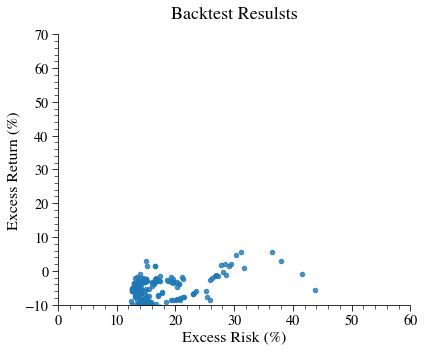

In [9]:
# risk-return plot 
results_df[['excess_return', 'excess_risk']]\
    .rename(
        columns={
            'excess_return':'Excess Return (%)', 
            'excess_risk':'Excess Risk (%)'
        })\
    .plot(
        kind='scatter', 
        x='Excess Risk (%)', 
        y='Excess Return (%)', 
        title='Backtest Resulsts', 
        alpha=0.8,
        figsize=(6,5),
        c='C0')

# x and y axis limits
plt.xlim(left=0.0, right=60.0)
plt.ylim(bottom=-10.0, top=70.0)

In [10]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.


In [11]:
agent.policy